In [1]:
import sys
import numpy as np
import scipy.interpolate as si
import os
import scipy.optimize
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, expanduser

sys.path.append("../src")  # relative path from notebooks/ to src/
import JCM_models.xray_compounds as xc
import JCM_models.jcm_plotting_utils as JCMgrid
from JCM_models import Shape, corner_round

#import geo_3 as geometry
#print(os.path.expanduser('~')) 
home = os.path.expanduser('~')


#jcm_root = join(home,'JCMwave/JCMsuite_6_2_1/ThirdPartySupport/Python')
jcm_root = join(home,'JCMwave/JCMsuite_6_4_8/ThirdPartySupport/Python')
sys.path.append(jcm_root)
import jcmwave

import pint
unit = pint.UnitRegistry()

#import pythia.Misc as MISC

#from paramiko import SSHClient

#import json

import pandas as pd

import pickle 

#import xraylib

import time

import matplotlib as mpl
import matrixmethod as mm
mpl.rcParams['font.family'] = ['sans']
mpl.rcParams['font.serif'] = ['DejaVu Sans']

In [2]:
jcmwave.daemon.shutdown()
jcmwave.daemon.add_workstation(
    Hostname="localhost",
    # Login='andrle01',
    Multiplicity=3,
    NThreads=12,
)

[845792509, 2086334444, 1775321727]

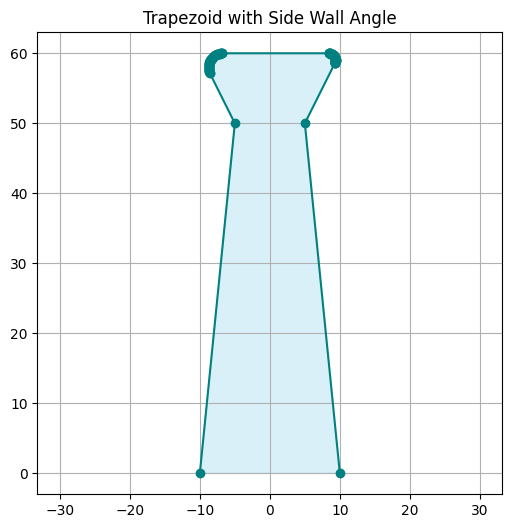

🔷 Shape: Stack_trapezoids
• Rounded corners:
   - Corner 3 → radius 2.0 (index out of bounds)
   - Corner 2 → radius 1.0 (index out of bounds)
• Centered option available via `.centered()`


In [70]:
import math
import matplotlib.pyplot as plt

class ShapeGenerator:
    def __init__(self, shape_type, params, offset_x=0, offset_y=0):
        self.shape_type = shape_type.lower()
        self.params = params
        self.offset_x = offset_x
        self.offset_y = offset_y

    def generate(self):
        shape_map = {
            'rectangle': self._rectangle,
            'stack_trapezoids': self._stack_trapezoids,
            'trapezoid': self._trapezoid
        }
        shape_func = shape_map.get(self.shape_type)
        if not shape_func:
            raise ValueError(f"Unsupported shape type: {self.shape_type}")

        coords = shape_func()

        # Check for embedded corner radii
        corner_radii = self.params.get('corner_radii')
        if corner_radii:
            coords = self._apply_corner_radii(coords, corner_radii)

        return coords


    def flatten(self,centered= False):
        if centered:
            coords = self.centered()
        else:
            coords = self.generate()
        return [coord for point in coords for coord in point]

    def centered(self):
        """Returns coordinates with x-axis centered at zero."""
        coords = self.generate()
        x_vals = [pt[0] for pt in coords]
        x_center = (max(x_vals) + min(x_vals)) / 2
        return [(x - x_center, y) for (x, y) in coords]
    
    def _apply_corner_radii(self, coords, corner_radii, n=50):
        """Applies per-corner rounding based on corner_radii dict."""
        rounded_coords = []
        for i in range(len(coords)):
            if i in corner_radii:
                r = corner_radii[i]
                x1 = coords[i - 1]
                x2 = coords[i]
                x3 = coords[(i + 1) % len(coords)]
                arc = corner_round(x1, x2, x3, r, n)
                rounded_coords.extend(arc)
            else:
                rounded_coords.append(coords[i])
        return rounded_coords

    def _stack_trapezoids(self):
        heights = self.params.get('height')
        widths = self.params.get('width')  # length must be len(heights) + 1

        if not (isinstance(heights, list) and isinstance(widths, list)):
            raise ValueError("'height' and 'width' must be lists")
        if len(widths) != len(heights) + 1:
            raise ValueError("Length of 'width' must be one more than 'height'")

        shapes_right = []
        shapes_left = []
        y_cursor = self.offset_y

        for i in range(len(heights)):
            h = heights[i]
            bottom_w = widths[i]
            top_w = widths[i + 1]

            # Coordinates from bottom left, clockwise
            coords_right = [
                (self.offset_x + bottom_w / 2, y_cursor),
                (self.offset_x + top_w / 2, y_cursor + h),
            ]
            coords_left = [
                (self.offset_x - bottom_w / 2, y_cursor),
                (self.offset_x - top_w / 2, y_cursor + h)
            ]

            shapes_right.extend(coords_right)
            shapes_left.extend(coords_left)
            y_cursor += h 
        unique_right = sorted(set(shapes_right), key=lambda pt: pt[1])  # bottom to top
        unique_left = sorted(set(shapes_left), key=lambda pt: pt[1], reverse=True)  # top to bottom

        return unique_right + unique_left





    def _rectangle(self):
        h = self.params.get('height')
        w = self.params.get('width')
        if h is None or w is None:
            raise ValueError("Rectangle requires 'height' and 'width'")

        return [            
            (self.offset_x + w, self.offset_y),
            (self.offset_x + w, self.offset_y + h),
            (self.offset_x, self.offset_y + h),
            (self.offset_x, self.offset_y),
        ]


    def _trapezoid(self):
        h = self.params.get('height')
        mid_w = self.params.get('width')
        angle_deg = 90-self.params.get('side_angle_deg')
        if h is None or mid_w is None or angle_deg is None:
            raise ValueError("Trapezoid requires 'height', 'width', and 'side_angle_deg' 'width' is at half height")

        angle_rad = math.radians(angle_deg)
        half_height = h / 2
        offset = half_height * math.tan(angle_rad)

        bottom_w = mid_w + 2 * offset
        top_w = mid_w - 2 * offset

        # Clamp top width to zero if negative
        top_w = max(0, top_w)

        # Coordinates from bottom left, clockwise
        return [
            
            (self.offset_x + bottom_w / 2, self.offset_y),
            (self.offset_x + top_w / 2, self.offset_y + h),
            (self.offset_x - top_w / 2, self.offset_y + h),
            (self.offset_x - bottom_w / 2, self.offset_y),
        ]
    

    def plot(self, ax=None, title=None):
        coords = self.generate()
        x, y = zip(*coords)
        if ax is None:
            fig  = plt.figure(figsize=(6, 6))
            plt.plot(x, y, marker='o', linestyle='-', color='teal')
            plt.fill(x, y, alpha=0.3, color='skyblue')
            plt.title(title or f"{self.shape_type.capitalize()} Shape")
            plt.axis('equal')
            plt.grid(True)
            plt.show()
            return fig
        else:
            ax.plot(x, y, marker='o', linestyle='-', color='teal')
            ax.fill(x, y, alpha=0.3, color='skyblue')
            return ax


    def describe(self):
        lines = [f"🔷 Shape: {self.shape_type.capitalize()}"]

        # Shape-specific parameter keys
        shape_params = {
            'rectangle': ['height', 'width'],
            'trapezoid': ['height', 'width', 'side_angle_deg'],
            'stacked_trapezoids': ['height', 'width']
        }

        used_keys = shape_params.get(self.shape_type, [])
        for key in used_keys:
            if key in self.params:
                lines.append(f"• {key.replace('_', ' ').capitalize()}: {self.params[key]}")

        # Stacked trapezoid narration
        if self.shape_type == 'stacked_trapezoids':
            heights = self.params.get('height', [])
            widths = self.params.get('width', [])
            spacing = self.params.get('spacing', 0)

            if isinstance(heights, list) and isinstance(widths, list) and len(widths) == len(heights) + 1:
                lines.append("• Layer transitions:")
                for i in range(len(heights)):
                    lines.append(f"   - Layer {i}: height {heights[i]}, bottom width {widths[i]}, top width {widths[i+1]}")
                if spacing:
                    lines.append(f"• Vertical spacing between layers: {spacing}")

        # Corner rounding
        corner_radii = self.params.get('corner_radii')
        if corner_radii:
            if self.shape_type == 'rectangle':
                raw_coords = self._rectangle()
            elif self.shape_type == 'trapezoid':
                raw_coords = self._trapezoid()
            elif self.shape_type == 'stacked_trapezoids':
                raw_coords = self._stack_trapezoids()
            else:
                raw_coords = []

            lines.append("• Rounded corners:")
            for i, r in corner_radii.items():
                if i < len(raw_coords):
                    x, y = raw_coords[i]
                    lines.append(f"   - Corner {i} at ({x:.2f}, {y:.2f}) → radius {r}")
                else:
                    lines.append(f"   - Corner {i} → radius {r} (index out of bounds)")

        # Offset
        if self.offset_x != 0 or self.offset_y != 0:
            lines.append(f"• Offset: x = {self.offset_x}, y = {self.offset_y}")

        # Centering hint
        lines.append("• Centered option available via `.centered()`")

        return "\n".join(lines)

# Example usage
params = {'height': [50,10], 'width': [20,10,20],'corner_radii': {3: 2.0, 2: 1.0}}
gen = ShapeGenerator('stack_trapezoids', params)

gen.plot(title="Trapezoid with Side Wall Angle")
print(gen.describe())

In [66]:
gen.generate() #.flatten()

[(5.0, 50), (10.0, 0), (10.0, 60), (-5.0, 50), (-10.0, 60), (-10.0, 0)]

In [3]:
thick = np.array([20,35,1.2] )
rough = np.array([0,0,0,0] )
wl = [13.5]
ang_deg = np.array([90])#np.linspace(0.1, 2.0, 10001)
ang = np.deg2rad(ang_deg)
nk_TOK = [1-0.023+0.00419j]
nk_Chaucer = [1-0.0226+0.0048j]
nk_SOG = [1-0.0195-0.006j]
nk_sub = np.conjugate(xc.refractive_index('Si',wl* unit.nm,density=2.33))
nk_sub_oxid = np.conjugate(xc.refractive_index('SiO2',wl* unit.nm,density=2.0929729034348785))

thick_noUL = np.array([20,1.2] )
rough_noUL = np.array([0,0,0] )
keys = {'uol1': 1e-9,
        'fem_deg': 4,}

#keys['energy'] = energy[i_taken_energy].to(unit.keV, 'sp').magnitude
#print(keys['energy'])
keys['pol'] = [1, 0] #1,0 s pol 0,1 p pol
keys['lamb'] = wl[0] * 1e-9
keys['slc'] = 1
slc=1
keys['nk'] = [ 1 + 0 * 1j, #vacuum
              nk_TOK, #nk_Si3N4, #layer on top of the substrate
              nk_SOG, #material of the grating
            nk_sub_oxid, #Background
              nk_sub, #surface_matt
             ]
keys['name_domain'] = ['vacuum','resist','UL','oxide','substrate']

pitch = 2
p2 = pitch /2
substrate_offset = 30
vacuum_offset = 30
y = np.sum(thick)

keys['points_cd'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,y+vacuum_offset,-p2,y+vacuum_offset])
keys['points_substrate'] = np.array([-p2,-substrate_offset,p2,-substrate_offset,p2,0,-p2,0])
keys['points_substrate_oxide'] = np.array([-p2,0,p2,0,p2,thick[-1],-p2,thick[-1]])
keys['points_UL'] = np.array([-p2,thick[-1],p2,thick[-1],p2,np.sum(thick[-2:]),-p2,np.sum(thick[-2:])])
keys['points_resist'] = np.array([-p2,np.sum(thick[-2:]),p2,np.sum(thick[-2:]),p2,y,-p2,y])

shape = [
    Shape('ComputationalDomain',domain_id = 1,priority=-1,side_length_constraint=slc,points=keys['points_cd'], nk = 1 ),
    Shape('substrate',domain_id = 2,priority=1,side_length_constraint=slc,points=keys['points_substrate'], nk = nk_sub ),
    Shape('substrate_oxide',domain_id = 3,priority=2,side_length_constraint=slc,points=keys['points_substrate_oxide'], nk = nk_sub_oxid ),
    Shape('UL',domain_id = 4,priority=2,side_length_constraint=slc,points=keys['points_UL'], nk = nk_SOG ),
    Shape('resist',domain_id = 5,priority=2,side_length_constraint=slc,points=keys['points_resist'], nk = nk_TOK ),
]
shape[0].domain_id
keys['shape']=shape
keys['energy_index'] = 0

In [61]:
print(shape[0].describe())

Shape: ComputationalDomain
  Domain ID: 1
  Priority: -1
  Side Length Constraint: 1
  Refractive Index (nk): 1
  Permittivity (ε): 1



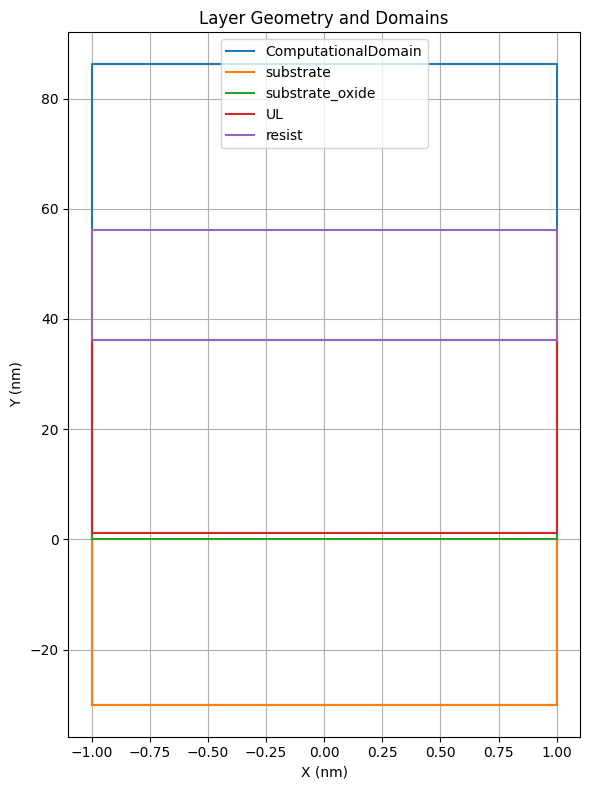

In [5]:
import matplotlib.pyplot as plt

# Create a shared figure and axis
fig, ax = plt.subplots(figsize=(6, 8))

# Plot each shape
for s in shape:
    s.plot(ax=ax)

# Final touches
ax.set_xlabel("X (nm)")
ax.set_ylabel("Y (nm)")
ax.set_title("Layer Geometry and Domains")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [48]:
jcmwave.geo("../JCM_clean/",keys=keys)

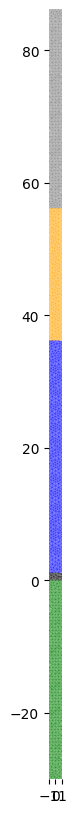

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))

JCMgrid.plot_grid(
    "../JCM_clean/grid.jcm",
    ax=ax,
    colors={1: "grey", 2: "green", 3: "black", 4: "blue", 5: "orange", 6: "pink"},
    alpha=0.5,
    lw=0.2,
)
ax.set_xlim(-p2, p2)
ax.set_ylim(-substrate_offset, y+vacuum_offset)
ax.set_frame_on(False)
# remove ticks and labels
#ax.set_xticks([])
#ax.set_yticks([])
ax.set_aspect("equal")

In [7]:
ids = []

keys['slc'] = 0.7

keys['phi']=90
keys['angle_of_incidence']= 0 #-82 #87.285796
#results = jcmwave.solve("./BlazedGrating/JCM_clean/project.jcmpt",keys=keys)
ids.append(
    jcmwave.solve('../JCM_clean/project-field.jcmpt',  keys=keys, temporary=True)
)
#results = [results]

results, logs = jcmwave.daemon.wait(ids, verbose=False)

In [8]:
results

[[{'file': '/tmp/__JCMwave__4qvnxkhu/project-field_results/fieldbag.jcm',
   'computational_costs': {'title': 'ComputationalCosts',
    'header': {'AccumulatedCPUTime': 3.370329,
     'AccumulatedTotalTime': 0.539170279},
    'Level': array([0], dtype=int32),
    'Unknowns': array([43136], dtype=int32),
    'CpuTime': array([3.174451]),
    'CpuPerUnknown': array([7.35916868e-05]),
    'TotalTime': array([0], dtype=int32),
    'SystemMemory_GB': array([0.02986145]),
    'MaxNodeSystemMemory_GB': array([0.02986145]),
    'TotalMemory_GB': array([0.1755867]),
    'MaxNodeTotalMemory_GB': array([0.1755867]),
    'CpuTimeAssembling': array([0.520478]),
    'CpuTimeSolve': array([0.435197]),
    'CpuTimeInnerNodeUpdate': array([0.131794]),
    'TotalTimeAssembling': array([0.05694267]),
    'TotalTimeSolve': array([0.07471476]),
    'TotalTimeInnerNodeUpdate': array([0.01077609]),
    'FEDegree0_Percentage': array([0.]),
    'FEDegree1_Percentage': array([0.]),
    'FEDegree2_Percentage': a